# Modeling
This notebook contains the modeling code for asthma, and predicting asthma from smoke estimates from 2025-2050.

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr

## Loading the Data

In [ ]:
# Smoke Estimate data
smoke_cleaned = pd.read_csv('../data_clean/norman_wildfires_SI_yearly_average.csv')
yearly_smoke_estimate_df = smoke_cleaned[['Year', 'Smoke_Estimate']]
yearly_smoke_estimate_df.set_index('Year', inplace=True)

# Non-smoker asthma survery data
non_smoker_asthma_survey_cleaned = pd.read_csv('../data_clean/asthma_non-smoker_survey_cleaned.csv')
yearly_non_smoker_asthma_df = non_smoker_asthma_survey_cleaned[['Year', 'Percentage']]
yearly_non_smoker_asthma_df.set_index('Year', inplace=True)

# Predicted Smoke Estimate data
smoke_estimate_preds_2025_2050 = pd.read_csv("../data_clean/forecasted_smoke_estimate.csv")

## Visualizing year-over-year non-smoker asthma percentage and Smoke Estimate
We start by visualizing the non-smoker asthma percentage and the smoke estimate from the years 2003-2020, for which we have both datasets.

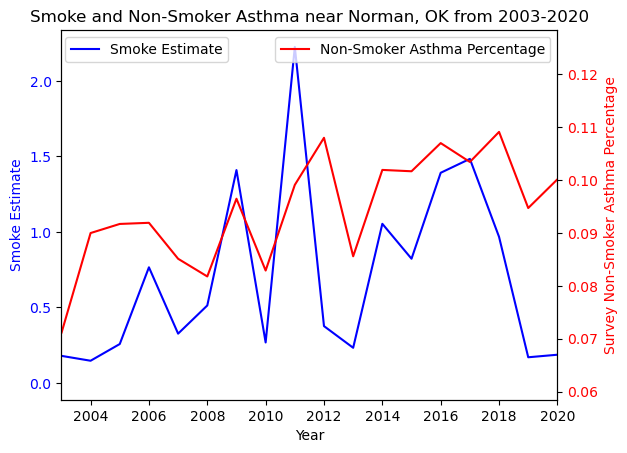

In [72]:
# Define subplots so we can plot on top of each other
fig, ax_si = plt.subplots()

#Plot the smoke estimate
ax_si.plot(smoke_cleaned['Year'].astype(int), smoke_cleaned['Smoke_Estimate'], color='blue', label='Smoke Estimate')
ax_si.set_xlabel("Year")
ax_si.set_ylabel("Smoke Estimate", color='blue')
ax_si.tick_params(axis="y", labelcolor="blue")
ax_si.legend(loc='upper right', bbox_to_anchor=(0.35, 1))

# Plot the AQI estimate
ax_aqi = ax_si.twinx()
ax_aqi.plot(non_smoker_asthma_survey_cleaned['Year'].astype(int), non_smoker_asthma_survey_cleaned['Percentage'], color='red', label='Non-Smoker Asthma Percentage')
ax_aqi.set_ylabel("Survey Non-Smoker Asthma Percentage", color='red')
ax_aqi.tick_params(axis="y", labelcolor="red")
ax_aqi.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.xlim([2003, 2020])
plt.title("Smoke and Non-Smoker Asthma near Norman, OK from 2003-2020")
plt.show()

Here, we see that there does seem to be a fair bit of alignment between the two, where in general they are both increasing, and the spikes in one are fairly consistent with the spikes in the other.

## Linear Regression: Smoke Estimate vs Non-Smoker Asthma
After observing a general alignment in between non-smoker asthma and the Smoke Estimate, we next convert this to more traditional statistical methods to formally analyze the relationship. First, we compute a pearson correlation coeffecient between the two variables, and next perform a simple linear regression, using the smoke estimate as the predictor, and asthma as the prediction. Lastly we visualize the results in the form of a scatter plot, and the plotted line of best fit from the linear regression. 

Note that this modeling technique does have a few drawbacks, but was chosen primarily for its simplicity and explanability. Firstly, by using linear regression, we are ignoring any temporal (year-over-year) component of the relationship. Additionally, there are a variety of linear regression assumptions that may not completely hold in this scenario, first and foremost the independence of observations (which is most definitely violated due to the temporal nature of the data). Despite these violations, linear regression is still able to give a simple and interpretable prediction of asthma (non-zero coefficient with p-value below 0.05) the lienar regression model does appear to be able to capture at least some of the relationship between asthma and smoke.

c:\Users\ajnet\anaconda3\envs\DATA557\lib\site-packages\scipy\stats\_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  k, _ = kurtosistest(a, axis)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     5.810
Date:                Wed, 27 Nov 2024   Prob (F-statistic):             0.0283
Time:                        21:40:20   Log-Likelihood:                 59.944
No. Observations:                  18   AIC:                            -115.9
Df Residuals:                      16   BIC:                            -114.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0882      0.003     25.875      0.0

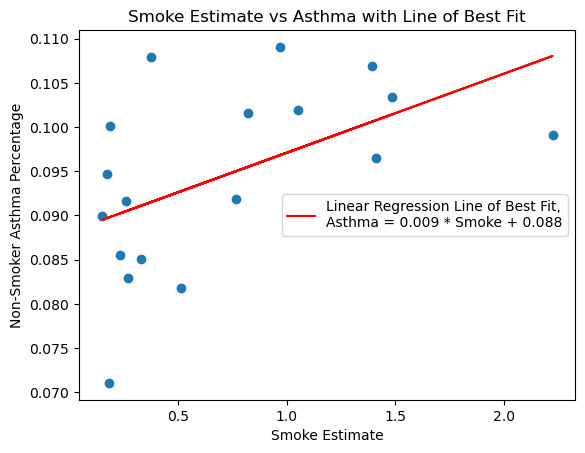

In [ ]:
smoke_cleaned_02_20 = smoke_cleaned[smoke_cleaned['Year'].between(2003, 2020)]
non_smoker_asthma_survey_cleaned_02_20 = non_smoker_asthma_survey_cleaned[non_smoker_asthma_survey_cleaned['Year'].between(2003, 2020)]

# Convert to numpy and normalize feature vector
smoke = np.array(smoke_cleaned_02_20['Smoke_Estimate'])
non_smoker_asthma = np.array(non_smoker_asthma_survey_cleaned_02_20['Percentage'])

# Compute Pearson correlation coeffecient
corr, p_value = pearsonr(smoke, non_smoker_asthma)

print("Pearson Correlation Coefficient:", corr)
print("P-value:", p_value)

# Fit a SLR model
non_smoker_asthma_model_smoke = sm.OLS(non_smoker_asthma, sm.add_constant(smoke)).fit()
print(non_smoker_asthma_model_smoke.summary())
non_smoker_asthma_preds_fit = non_smoker_asthma_model_smoke.get_prediction(sm.add_constant(smoke)).predicted_mean

plt.scatter(smoke, non_smoker_asthma)
plt.plot(smoke, non_smoker_asthma_preds_fit, color='r', label=f'Linear Regression Line of Best Fit,\nAsthma = {non_smoker_asthma_model_smoke.params[1]:.3f} * Smoke + {non_smoker_asthma_model_smoke.params[0]:.3f}')
plt.xlabel('Smoke Estimate')
plt.ylabel('Non-Smoker Asthma Percentage')
plt.title('Smoke Estimate vs Asthma with Line of Best Fit')
plt.legend(loc='center right')

## Forecast Asthma Predictions from 2025-2050
After developing the linear regression model, we can use it to forecast asthma predictions based on the outputs from our forecasted smoke estimate values, from the years 2025-2050.

Note that one challenge in this analysis is accurately estimating the confidence intervals associated with these asthma predictions. We can directly obtain confidence intervals from our linear regression model, but since the inputs themselves are smoke estimate with their own uncertainty, to accurately quantify our overall prediction uncertainty, we need a method for aggregating the combined confidence intervals. In this analysis, we take a conservative approach, and to compute the upper and lower bound, we take the 95% upper bound from the linear regression output when we input the 95% upper bound smoke estimate forecast value (and the opposite for the lower bound). This approach is conservative (i.e. gives us wider confidence intervals) than if we just used the 95% CI from the regression output with the mean forecasted value, but likely does a more accurate job in representing the uncertainty of the prediction. 

Overall, we see that our model predicts a long-term steady increase in asthma rates (with high uncertainty in any specific year).

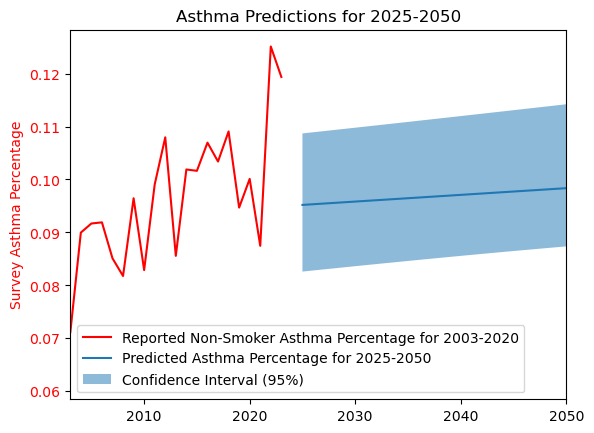

In [123]:
#Extract the Smoke Estimate column
smoke_estimates_2025_2050 = np.array(smoke_estimate_preds_2025_2050["Smoke_Estimate"])

#Use the model to perform inference
non_smoker_asthma_preds_fit_2025_2050_fit = non_smoker_asthma_model_smoke.get_prediction(sm.add_constant(smoke_estimates_2025_2050))
non_smoker_asthma_preds_fit_2025_2050 = non_smoker_asthma_preds_fit_2025_2050_fit.predicted_mean

#Compute conservative confidence intervals
upper_bound_nsapf_fit = non_smoker_asthma_model_smoke.get_prediction(sm.add_constant(np.array(smoke_estimate_preds_2025_2050["Upper_bound"])))
upper_upper_bound_nsapf = upper_bound_nsapf_fit.conf_int()[:, 1]
upper_bound_nsapf = upper_bound_nsapf_fit.predicted_mean

lower_bound_nsapf_fit = non_smoker_asthma_model_smoke.get_prediction(sm.add_constant(np.array(smoke_estimate_preds_2025_2050["Lower_bound"])))
lower_lower_bound_nsapf = lower_bound_nsapf_fit.conf_int()[:, 0]
lower_bound_nsapf = lower_bound_nsapf_fit.predicted_mean

#Plot the Forecast results
plt.plot(non_smoker_asthma_survey_cleaned['Year'].astype(int), non_smoker_asthma_survey_cleaned['Percentage'], color='red', label='Reported Non-Smoker Asthma Percentage for 2003-2020')
plt.plot(smoke_estimate_preds_2025_2050['Year'], non_smoker_asthma_preds_fit_2025_2050, label='Predicted Asthma Percentage for 2025-2050')
plt.fill_between(smoke_estimate_preds_2025_2050['Year'], upper_upper_bound_nsapf, lower_lower_bound_nsapf, alpha=0.5, label='Confidence Interval (95%)')
plt.ylabel("Survey Asthma Percentage", color='red')
plt.tick_params(axis="y", labelcolor="red")
plt.legend()
plt.xlim([2003, 2050])
plt.title("Asthma Predictions for 2025-2050")
plt.show()